In [1]:
# 1- Read the data into a Pandas dataframe.
# 2- Analyze extracted features and transform them. You may need to encode some categorical variables, 
  # or scale numerical variables.
    # 3- Create a query to get the list of films and a boolean indicating if it was rented last month. 
  # This would be our target variable.
    # 4- Create a logistic regression model to predict this variable from the cleaned data.
# 5- Evaluate the results.

In [242]:
import imblearn
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
password = getpass.getpass()

········


In [17]:
import mysql.connector

In [209]:
#db_config = 
    #'host': 'localhost',
    #'user': 'root',
    #'password': 'Caracolillo666',
    #'database': 'sakila'

connection_string = 'mysql+pymysql://root:' + 'Caracolillo666' + '@localhost/sakila'
engine = create_engine(connection_string)

query = """
SELECT
  c.customer_id,
  f.film_id,
  r.rental_id,
  r.rental_date,
  r.return_date,
  r.inventory_id,
  TIMESTAMPDIFF(HOUR, r.rental_date, r.return_date) AS rental_duration,
  cat.category_id,
  cat.name AS category_name,
  f.rating
FROM
  film f
JOIN
  inventory i ON f.film_id = i.film_id
JOIN
  rental r ON i.inventory_id = r.inventory_id
JOIN
  customer c ON r.customer_id = c.customer_id
JOIN
  film_category fc ON f.film_id = fc.film_id
JOIN
  category cat ON fc.category_id = cat.category_id;

"""
df_original = pd.read_sql_query(query, engine)

In [210]:
df_original.head(3)

,customer_id,film_id,rental_id,rental_date,return_date,inventory_id,rental_duration,category_id,category_name,rating
0,77,19,10895,2005-08-02 01:16:59,2005-08-03 02:41:59,93,25.0,1,Action,PG
1,39,19,12268,2005-08-18 04:26:54,2005-08-23 06:40:54,93,122.0,1,Action,PG
2,34,19,3150,2005-06-20 20:35:28,2005-06-26 01:01:28,94,124.0,1,Action,PG


In [211]:
df_original.columns = df_original.columns.str.replace("_", " ").str.capitalize()

In [212]:
df_copy = df_original.copy()
df_copy.dtypes

Customer id                 int64
Film id                     int64
Rental id                   int64
Rental date        datetime64[ns]
Return date        datetime64[ns]
Inventory id                int64
Rental duration           float64
Category id                 int64
Category name              object
Rating                     object
dtype: object

In [213]:
def convert_to_time_category(time_str):
    try:
        time_dt = pd.to_datetime(time_str, format='%Y-%m-%d %H:%M:%S', errors='raise')

        if 6 <= time_dt.hour < 12:
            return 'morning'
        elif 12 <= time_dt.hour < 18:
            return 'afternoon'
        elif 18 <= time_dt.hour < 21:
            return 'late afternoon'
        else:
            return 'night'
    except ValueError:
        return ''

df_copy['Rental date'] = df_copy['Rental date'].apply(convert_to_time_category)
df_copy['Return date'] = df_copy['Return date'].apply(convert_to_time_category)

In [214]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16046 entries, 0 to 16045
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Customer id      16046 non-null  int64  
 1   Film id          16046 non-null  int64  
 2   Rental id        16046 non-null  int64  
 3   Rental date      16046 non-null  object 
 4   Return date      16046 non-null  object 
 5   Inventory id     16046 non-null  int64  
 6   Rental duration  15861 non-null  float64
 7   Category id      16046 non-null  int64  
 8   Category name    16046 non-null  object 
 9   Rating           16046 non-null  object 
dtypes: float64(1), int64(5), object(4)
memory usage: 1.2+ MB


In [215]:
df_copy.isna().sum()

Customer id          0
Film id              0
Rental id            0
Rental date          0
Return date          0
Inventory id         0
Rental duration    185
Category id          0
Category name        0
Rating               0
dtype: int64

In [216]:
df_copy = df_copy.dropna()
df_copy = df_copy.fillna(0)

In [217]:
df_copy.shape

(15861, 10)

In [218]:
df_copy.describe()

,Customer id,Film id,Rental id,Inventory id,Rental duration,Category id
count,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000
mean,297.259567,501.288191,7959.654562,2292.658849,120.115882,8.364542
std,172.375305,288.411898,4616.463306,1321.735332,62.203561,4.648246
min,1.000000,1.000000,1.000000,1.000000,18.000000,1.000000
25%,148.000000,255.000000,3968.000000,1157.000000,68.000000,4.000000
50%,296.000000,498.000000,7934.000000,2293.000000,120.000000,8.000000
75%,446.000000,753.000000,11920.000000,3432.000000,171.000000,13.000000
max,599.000000,1000.000000,16049.000000,4581.000000,221.000000,16.000000


<Axes: xlabel='Rental duration', ylabel='Count'>

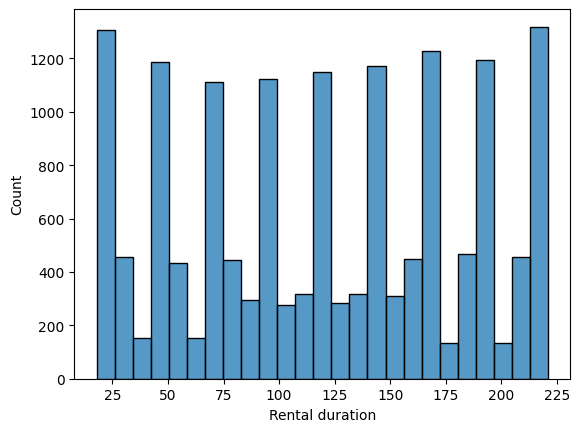

In [219]:
sns.histplot(data=df_copy, x='Rental duration')

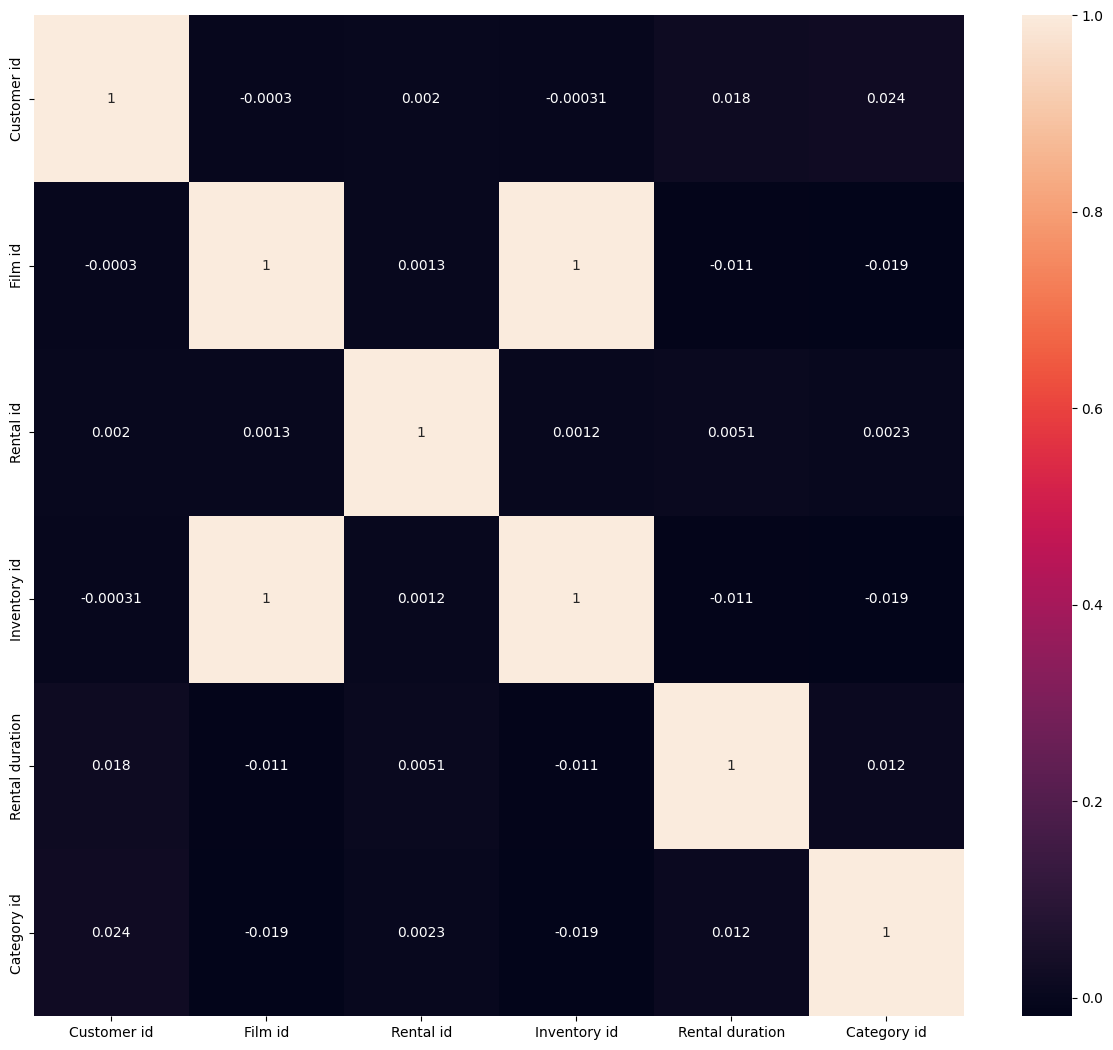

In [220]:
corr_matrix = df_copy.select_dtypes("number").corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(15, 13))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

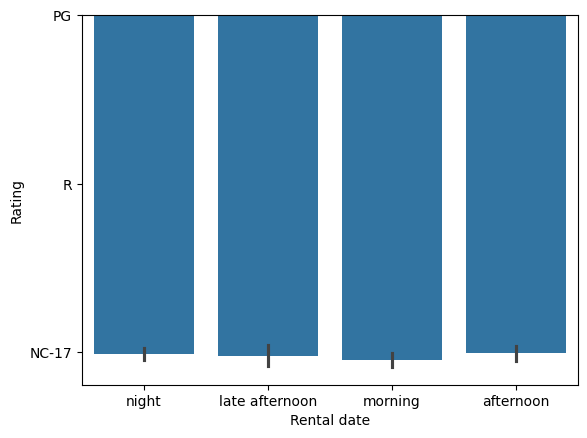

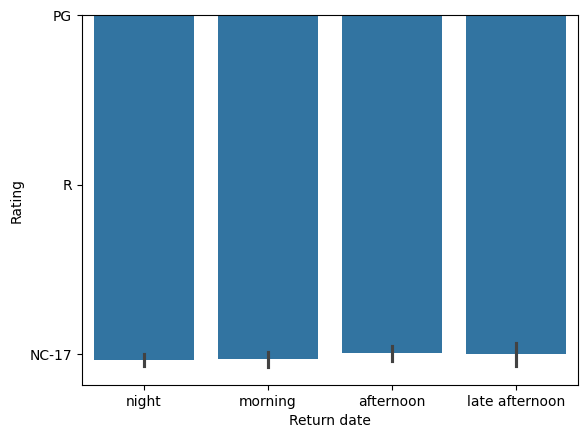

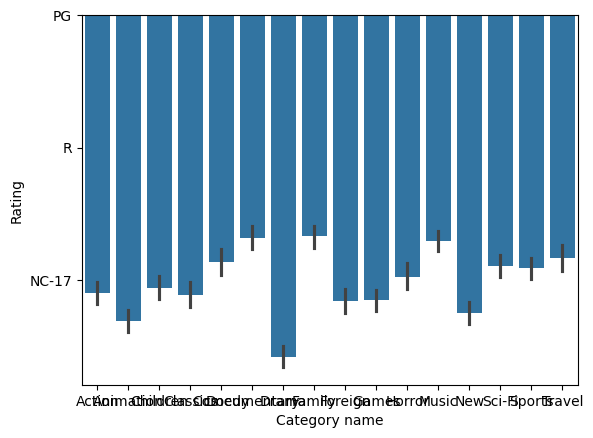

In [222]:
for col in df_copy.drop("Rating", axis=1).select_dtypes("object"):
    sns.barplot(x=df_copy[col], y=df_copy["Rating"])
    plt.show()

In [223]:
numerical_data = df_copy.select_dtypes(include=["float64", "int64"])
categorical_data = df_copy.select_dtypes("object")

In [224]:
df_copy['Rating'].value_counts()

Rating
PG-13    3543
NC-17    3249
PG       3177
R        3152
G        2740
Name: count, dtype: int64

In [225]:
X = pd.get_dummies(df_copy.drop('Rating', axis=1)) # watch out! rookie mistake: DO NOT dummify the target variable
y = df_copy['Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

classification = LogisticRegression(random_state=42, max_iter=10000)
classification.fit(X_train, y_train)

predictions = classification.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           G       0.22      0.13      0.16       548
       NC-17       0.26      0.34      0.29       650
          PG       0.30      0.06      0.10       636
       PG-13       0.25      0.61      0.35       709
           R       0.20      0.03      0.05       630

    accuracy                           0.25      3173
   macro avg       0.25      0.24      0.19      3173
weighted avg       0.25      0.25      0.20      3173



In [233]:
query = """
SELECT
    f.film_id,
    f.title,
    MAX(f.rating) AS Target
FROM
    film f
LEFT JOIN
    inventory i ON f.film_id = i.film_id
LEFT JOIN
    rental r ON i.inventory_id = r.inventory_id
GROUP BY
    f.film_id, f.title;
"""

df_result = pd.read_sql_query(query, engine)
df_result.columns = df_result.columns.str.replace("_", " ").str.capitalize()
df_result.head(5)

,Film id,Title,Target
0,1,ACADEMY DINOSAUR,PG
1,2,ACE GOLDFINGER,G
2,3,ADAPTATION HOLES,NC-17
3,4,AFFAIR PREJUDICE,G
4,5,AFRICAN EGG,G


In [234]:
df_result['Target'].value_counts()

Target
PG-13    223
NC-17    210
R        195
PG       194
G        178
Name: count, dtype: int64

In [235]:
selected_columns = ['Customer id', 'Film id', 'Rental id', 'Rental date', 'Return date',
       'Inventory id', 'Rental duration', 'Category id', 'Category name',
       'Rating']

df_filtered = df_copy[selected_columns].drop_duplicates(subset='Film id')

df_encoded = df_filtered.merge(df_result, left_on = "Film id", right_on = "Film id") 
df_encoded = pd.get_dummies(df_encoded, drop_first=True)
df_encoded

,Customer id,Film id,Rental id,Inventory id,Rental duration,Category id,Rental date_late afternoon,Rental date_morning,Rental date_night,Return date_late afternoon,...,Title_YENTL IDAHO,Title_YOUNG LANGUAGE,Title_YOUTH KICK,Title_ZHIVAGO CORE,Title_ZOOLANDER FICTION,Title_ZORRO ARK,Target_NC-17,Target_PG,Target_PG-13,Target_R
0,77,19,10895,93,25.0,1,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
1,47,21,207,102,25.0,1,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
2,448,29,1123,142,50.0,1,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
3,463,56,3309,248,188.0,1,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,13,67,3946,294,114.0,1,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953,7,931,117,4278,148.0,16,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
954,322,977,1588,4472,218.0,16,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
955,202,981,3148,4490,96.0,16,True,False,False,True,...,False,False,False,False,False,False,True,False,False,False
956,466,988,9202,4525,189.0,16,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [246]:
y = df_encoded[['Target_NC-17', 'Target_PG', 'Target_PG-13', 'Target_R']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

models = {}
for target_class in y.columns:
    model = LogisticRegression(random_state=42, max_iter=2000)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model.fit(X_train_scaled, y_train[target_class])
    models[target_class] = model

predictions = pd.DataFrame({target_class: model.predict(X_test_scaled) for target_class, model in models.items()})
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9965277777777778


In [247]:
# An accuracy of 0.9965 (or 99.65%) suggests that the logistic regression model is performing exceptionally well on the test
# dataset. This high accuracy indicates that the model is making accurate predictions for the target classes you're interested 
# in (NC-17, PG, PG-13, R)